In [35]:
%pip install gymnasium
%pip install stable_baselines3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt


In [57]:
import yfinance as yf
vgt_data = yf.download("VGT", start="2021-01-01", end="2023-04-30")
voo_data = yf.download("VOO", start="2021-01-01", end="2023-04-30")

data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [58]:
split_index = int(len(data) * 0.8)

In [59]:
#TRAINING


window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
    'stocks-v0',
    df = train_df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


In [60]:
#VALIDATION

window_size = 10
start_index = window_size
end_index = len(data)

val_env = gym.make(
    'stocks-v0',
    df = val_df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([lambda : train_env, lambda : val_env])

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [61]:
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, inf

-----------------------------
| time/              |      |
|    fps             | 3954 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------


In [62]:
obs = env.reset()

while True:
    action, _ = model.predict(obs)

    obs, reward, done, info = env.step(action)

    #env.render()
    
    if done.all():
        print("info:", info)
        break

info: [{'total_reward': 189.7199478149414, 'total_profit': 0.03317069051685119, 'position': 1, 'TimeLimit.truncated': False, 'terminal_observation': array([[ 4.12329987e+02, -3.13000488e+00],
       [ 4.11970001e+02, -3.59985352e-01],
       [ 4.14200012e+02,  2.23001099e+00],
       [ 4.16079987e+02,  1.87997437e+00],
       [ 4.16850006e+02,  7.70019531e-01],
       [ 4.13290009e+02, -3.55999756e+00],
       [ 4.08010010e+02, -5.27999878e+00],
       [ 4.11079987e+02,  3.06997681e+00],
       [ 4.16279999e+02,  5.20001221e+00],
       [ 4.22130005e+02,  5.85000610e+00]])}, {'total_reward': -21.39013671875, 'total_profit': 0.10332333842163377, 'position': 1, 'TimeLimit.truncated': False, 'terminal_observation': array([[ 3.80279999e+02,  1.29000854e+00],
       [ 3.80540009e+02,  2.60009766e-01],
       [ 3.80519989e+02, -2.00195312e-02],
       [ 3.78369995e+02, -2.14999390e+00],
       [ 3.78589996e+02,  2.20001221e-01],
       [ 3.79089996e+02,  5.00000000e-01],
       [ 3.73100006e

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


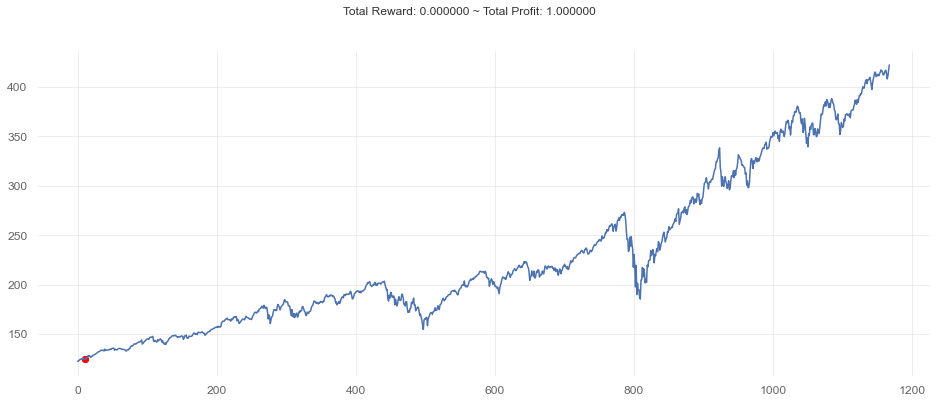

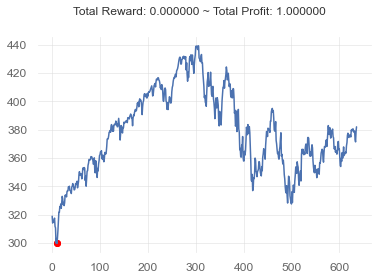

In [63]:
plt.figure(figsize=(16, 6))
for env in envs:
    env.render()
plt.show()

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'